In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [3]:
tf.random.set_seed(47)
np.random.seed(47)

In [4]:
# !pip install optuna > /dev/null

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
df = pd.read_csv('../input/stockdata/ADBL_data.csv')
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Open,High,Low,Close
0,2012-01-01,115.0,115.0,113.0,114.0
1,2012-01-02,114.0,118.0,115.0,118.0
2,2012-01-03,118.0,116.0,114.0,115.0
3,2012-01-04,115.0,115.0,113.0,114.0
4,2012-01-05,114.0,114.0,112.0,113.0


Using only Date and Close

In [9]:
df = df[['Date', 'Close']]

In [10]:
df.describe()

,Close
count,1911.00000
mean,406.92831
std,167.13069
min,101.00000
25%,313.00000
50%,420.00000
75%,480.00000
max,1082.00000


In [11]:
df.head()

,Date,Close
0,2012-01-01,114.0
1,2012-01-02,118.0
2,2012-01-03,115.0
3,2012-01-04,114.0
4,2012-01-05,113.0


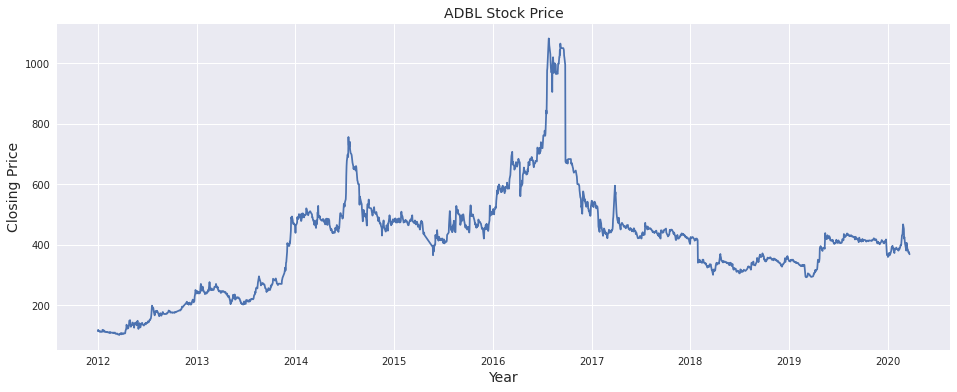

In [12]:
plt.title('ADBL Stock Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.plot(df['Date'], df['Close'])
plt.show()

# Generating features from target variable

In [13]:
# Percentage change is : (Todays price - yesterdays price) / yesterdays price
# For instance: (658.0 - 661.0) / 661.0
df['returns'] = df.Close.pct_change() * 100
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()

,Date,Close,returns
0,2012-01-02,118.0,3.508772
1,2012-01-03,115.0,-2.542373
2,2012-01-04,114.0,-0.869565
3,2012-01-05,113.0,-0.877193
4,2012-01-08,114.0,0.884956


In [15]:
data = df[['Close', 'returns']].values
data

array([[118.        ,   3.50877193],
       [115.        ,  -2.54237288],
       [114.        ,  -0.86956522],
       ...,
       [374.        ,  -1.05820106],
       [376.        ,   0.53475936],
       [368.        ,  -2.12765957]])

# Train, validation and test split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_data = train_test_split(data, test_size=0.20, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(1528, 2)
(191, 2)
(191, 2)


# Scaling input data

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Generating input features based on time step

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)


Train Samples: 1527
Validation Samples: 190
Test Samples: 190


# Scaling back output data to original Closing price

In [22]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [23]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(1527,) (190,) (190,)


In [24]:
x_train[1], y_train[0]

(array([[0.01427115, 0.70251106]]), 0.01427115188583078)

In [25]:
x_val[1], y_val[0]

(array([[0.23445464, 0.7485674 ]]), 0.23445463812436293)

In [26]:
x_test[1], y_test[0]

(array([[0.32008155, 0.75711126]]), 0.32008154943934763)

# LSTM Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers

## Hyperparameter Search

In [28]:
early_stopping_rounds = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)

In [29]:
# Objective function
def run(trial):
    space = {
        'optimizer':  trial.suggest_categorical('optimizer', [optimizers.Adam, optimizers.Adagrad, optimizers.Adamax, optimizers.Nadam, optimizers.RMSprop, optimizers.SGD]),
        'units_1': trial.suggest_int('units_1', 50, 4000, 50),
        'dropout_rate_1': trial.suggest_float('dropout_rate_1', 0.1, 0.6),
        'units_2': trial.suggest_int('units_2', 50, 4000, 50),
        'dropout_rate_2': trial.suggest_float('dropout_rate_2', 0.1, 0.6),
        'units_3': trial.suggest_int('units_3', 50, 4000, 50),
        'dropout_rate_3': trial.suggest_float('dropout_rate_3', 0.1, 0.6),
        'units_4': trial.suggest_int('units_4', 50, 4000, 50),
        'dropout_rate_4': trial.suggest_float('dropout_rate_4', 0.1, 0.6),
        'epochs': trial.suggest_int('epochs', 100, 5000, 50),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 8e-1)
    }

    model = Sequential()
    # Adding the first LSTM layer and some Dropout regularization
    model.add(LSTM(units=space['units_1'], return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(rate=space['dropout_rate_1']))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=space['units_2'], return_sequences = True))
    model.add(Dropout(rate=space['dropout_rate_2']))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=space['units_3'], return_sequences = True))
    model.add(Dropout(rate=space['dropout_rate_3']))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=space['units_4']))
    model.add(Dropout(rate=space['dropout_rate_4']))
    # Adding the output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(loss='mean_squared_error', optimizer=space['optimizer'](learning_rate=space['learning_rate']), metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=space['epochs'], validation_data=(x_val, y_val), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_train = np.squeeze(model.predict(x_train))
    yhat_val = np.squeeze(model.predict(x_val))

    yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
    yhat_val = scaler.inverse_transform(prep_data_transform(yhat_val, X_val.shape[1]))[:,0]

    nan_check = [np.isnan(yhat_train).any(), np.isnan(yhat_val).any()]
    print(nan_check)
    if True in nan_check:
        rmse = 99999
    else:
        rmse = mean_squared_error(Y_val, yhat_val, squared=False)
    return rmse

In [30]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=30)

[I 2021-11-02 05:46:19,612] A new study created in memory with name: no-name-e435421c-b73a-4985-aee6-22de439c5e08
2021-11-02 05:46:19.689673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 05:46:19.772915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 05:46:19.773609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 05:46:19.775284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critica

[False, False]


[I 2021-11-02 06:38:01,696] Trial 1 finished with value: 53.00853413673788 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 3600, 'dropout_rate_1': 0.44915389226354374, 'units_2': 3850, 'dropout_rate_2': 0.12992302763527128, 'units_3': 2450, 'dropout_rate_3': 0.2879523604033739, 'units_4': 3050, 'dropout_rate_4': 0.15772563127195413, 'epochs': 2300, 'batch_size': 32, 'learning_rate': 0.006647865251760402}. Best is trial 0 with value: 17.89917567899922.


[False, False]


[I 2021-11-02 06:41:24,416] Trial 2 finished with value: 74.4361307111165 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units_1': 3400, 'dropout_rate_1': 0.48731777999862913, 'units_2': 1950, 'dropout_rate_2': 0.2842075038222517, 'units_3': 1800, 'dropout_rate_3': 0.4449297195097748, 'units_4': 2550, 'dropout_rate_4': 0.5712177751257099, 'epochs': 3500, 'batch_size': 256, 'learning_rate': 0.08041909572538646}. Best is trial 0 with value: 17.89917567899922.


[False, False]


[I 2021-11-02 06:45:29,030] Trial 3 finished with value: 74.1042484516753 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units_1': 750, 'dropout_rate_1': 0.557559180001156, 'units_2': 2600, 'dropout_rate_2': 0.4720172897476538, 'units_3': 650, 'dropout_rate_3': 0.4952235006231197, 'units_4': 2700, 'dropout_rate_4': 0.31913997875978406, 'epochs': 950, 'batch_size': 64, 'learning_rate': 0.021408545647213457}. Best is trial 0 with value: 17.89917567899922.


[False, False]


[I 2021-11-02 06:48:43,666] Trial 4 finished with value: 7.63890552401081 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2500, 'dropout_rate_1': 0.14951357261005424, 'units_2': 900, 'dropout_rate_2': 0.3749070634801126, 'units_3': 1950, 'dropout_rate_3': 0.26509214469048625, 'units_4': 3150, 'dropout_rate_4': 0.4368722363568167, 'epochs': 4100, 'batch_size': 256, 'learning_rate': 0.002053577478753283}. Best is trial 4 with value: 7.63890552401081.


[False, False]


[I 2021-11-02 06:57:44,979] Trial 5 finished with value: 2231.728710016807 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 3950, 'dropout_rate_1': 0.44440968664717806, 'units_2': 2300, 'dropout_rate_2': 0.10084734499888529, 'units_3': 3250, 'dropout_rate_3': 0.4864157435950789, 'units_4': 1500, 'dropout_rate_4': 0.23395960172961358, 'epochs': 3000, 'batch_size': 64, 'learning_rate': 0.013587506527680775}. Best is trial 4 with value: 7.63890552401081.


[False, False]


[I 2021-11-02 07:10:35,214] Trial 6 finished with value: 11.224712430224507 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 2350, 'dropout_rate_1': 0.4780547942843134, 'units_2': 900, 'dropout_rate_2': 0.4423033079264983, 'units_3': 2400, 'dropout_rate_3': 0.3222128091778972, 'units_4': 1800, 'dropout_rate_4': 0.19487551437287962, 'epochs': 2750, 'batch_size': 128, 'learning_rate': 0.005701804817869916}. Best is trial 4 with value: 7.63890552401081.


[False, False]


[I 2021-11-02 07:36:27,904] Trial 7 finished with value: 133695.2883776371 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 3250, 'dropout_rate_1': 0.4689409890453491, 'units_2': 2050, 'dropout_rate_2': 0.19215090164900675, 'units_3': 1300, 'dropout_rate_3': 0.12262702277331175, 'units_4': 2950, 'dropout_rate_4': 0.1479665358402619, 'epochs': 1100, 'batch_size': 16, 'learning_rate': 0.3013197490058176}. Best is trial 4 with value: 7.63890552401081.


[False, False]


[I 2021-11-02 08:02:33,625] Trial 8 finished with value: 9043.19049771222 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 300, 'dropout_rate_1': 0.2482344637616665, 'units_2': 1650, 'dropout_rate_2': 0.1192333438083141, 'units_3': 1500, 'dropout_rate_3': 0.5162512278507445, 'units_4': 3300, 'dropout_rate_4': 0.575745642849186, 'epochs': 4950, 'batch_size': 32, 'learning_rate': 0.2316295834015568}. Best is trial 4 with value: 7.63890552401081.


[False, False]


[I 2021-11-02 09:50:54,753] Trial 9 finished with value: 6.859358971528525 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 2300, 'dropout_rate_1': 0.14392211465515845, 'units_2': 700, 'dropout_rate_2': 0.1030063385730394, 'units_3': 3150, 'dropout_rate_3': 0.4806478807165333, 'units_4': 3050, 'dropout_rate_4': 0.38305785950651283, 'epochs': 3300, 'batch_size': 16, 'learning_rate': 0.0020818425666182428}. Best is trial 9 with value: 6.859358971528525.


[False, False]


[I 2021-11-02 09:58:32,609] Trial 10 finished with value: 89.16115284997365 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units_1': 1550, 'dropout_rate_1': 0.10489083299806196, 'units_2': 100, 'dropout_rate_2': 0.5943547319718743, 'units_3': 4000, 'dropout_rate_3': 0.5962329202603471, 'units_4': 300, 'dropout_rate_4': 0.4298244989652299, 'epochs': 1650, 'batch_size': 16, 'learning_rate': 0.05326883523154378}. Best is trial 9 with value: 6.859358971528525.


[False, False]


[I 2021-11-02 10:04:01,985] Trial 11 finished with value: 7.136764084016272 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2600, 'dropout_rate_1': 0.11202108302890386, 'units_2': 850, 'dropout_rate_2': 0.37856407393006025, 'units_3': 3250, 'dropout_rate_3': 0.2435275719861279, 'units_4': 3900, 'dropout_rate_4': 0.41413353830554167, 'epochs': 4200, 'batch_size': 512, 'learning_rate': 0.0010352204405657353}. Best is trial 9 with value: 6.859358971528525.


[False, False]


[I 2021-11-02 10:07:51,412] Trial 12 finished with value: 6.579238373687748 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2750, 'dropout_rate_1': 0.22792165292975838, 'units_2': 50, 'dropout_rate_2': 0.3379162398571884, 'units_3': 3200, 'dropout_rate_3': 0.3967512484540226, 'units_4': 3800, 'dropout_rate_4': 0.3959732343048801, 'epochs': 4250, 'batch_size': 512, 'learning_rate': 0.0010512100721296591}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 10:11:43,334] Trial 13 finished with value: 15.950177672443713 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 2900, 'dropout_rate_1': 0.24716951069434506, 'units_2': 100, 'dropout_rate_2': 0.2945153013951589, 'units_3': 3450, 'dropout_rate_3': 0.4061433092788408, 'units_4': 3900, 'dropout_rate_4': 0.3385683080642317, 'epochs': 4950, 'batch_size': 512, 'learning_rate': 0.0041775270934702015}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 10:25:51,036] Trial 14 finished with value: 9.717824075817244 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 1800, 'dropout_rate_1': 0.2218500555348572, 'units_2': 500, 'dropout_rate_2': 0.5962500520011372, 'units_3': 2900, 'dropout_rate_3': 0.3884346689527454, 'units_4': 2200, 'dropout_rate_4': 0.5113136794028218, 'epochs': 3750, 'batch_size': 16, 'learning_rate': 0.0029877654123053425}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 10:30:12,952] Trial 15 finished with value: 74.38458102433925 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 1050, 'dropout_rate_1': 0.3138771486171533, 'units_2': 1350, 'dropout_rate_2': 0.5026417665665256, 'units_3': 3850, 'dropout_rate_3': 0.5935666149337672, 'units_4': 1150, 'dropout_rate_4': 0.28280456844526675, 'epochs': 2000, 'batch_size': 512, 'learning_rate': 0.010154388560950144}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 10:39:20,703] Trial 16 finished with value: 73.28709992163908 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units_1': 2100, 'dropout_rate_1': 0.17820549914125935, 'units_2': 3150, 'dropout_rate_2': 0.2085509095457293, 'units_3': 2800, 'dropout_rate_3': 0.3537930109668632, 'units_4': 4000, 'dropout_rate_4': 0.3839695325131772, 'epochs': 3400, 'batch_size': 512, 'learning_rate': 0.0012439769851314269}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 11:40:44,505] Trial 17 finished with value: 913.3709296690477 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 2850, 'dropout_rate_1': 0.3379899972730812, 'units_2': 550, 'dropout_rate_2': 0.29679544925578616, 'units_3': 100, 'dropout_rate_3': 0.5343426712790251, 'units_4': 3500, 'dropout_rate_4': 0.4982162499656346, 'epochs': 4300, 'batch_size': 16, 'learning_rate': 0.7519016885728478}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 11:47:06,257] Trial 18 finished with value: 7.95103287195589 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 1350, 'dropout_rate_1': 0.2904728613022567, 'units_2': 1350, 'dropout_rate_2': 0.5295622413943684, 'units_3': 3550, 'dropout_rate_3': 0.19591719485069242, 'units_4': 2300, 'dropout_rate_4': 0.2836225515499431, 'epochs': 4500, 'batch_size': 512, 'learning_rate': 0.0027742040822562467}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 11:56:11,637] Trial 19 finished with value: 47.82565841415889 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 3000, 'dropout_rate_1': 0.39353558817754986, 'units_2': 50, 'dropout_rate_2': 0.4321140695499215, 'units_3': 2700, 'dropout_rate_3': 0.4230231851656036, 'units_4': 800, 'dropout_rate_4': 0.47751826871592684, 'epochs': 250, 'batch_size': 16, 'learning_rate': 0.043564756445630105}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 12:30:53,335] Trial 20 finished with value: 40.086488039498335 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 2100, 'dropout_rate_1': 0.18391779427009208, 'units_2': 1300, 'dropout_rate_2': 0.17057980439036327, 'units_3': 3050, 'dropout_rate_3': 0.4575069462198438, 'units_4': 2750, 'dropout_rate_4': 0.37795046630130397, 'epochs': 3300, 'batch_size': 32, 'learning_rate': 0.010163466940185849}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 12:38:19,485] Trial 21 finished with value: 7.301473724494618 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2550, 'dropout_rate_1': 0.10866898002079309, 'units_2': 600, 'dropout_rate_2': 0.37441912591489696, 'units_3': 3600, 'dropout_rate_3': 0.20733700321184836, 'units_4': 3800, 'dropout_rate_4': 0.39007697058640456, 'epochs': 3950, 'batch_size': 512, 'learning_rate': 0.0010323246614424646}. Best is trial 12 with value: 6.579238373687748.


[False, False]


[I 2021-11-02 12:45:08,348] Trial 22 finished with value: 6.321012135097071 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2550, 'dropout_rate_1': 0.14865075581332382, 'units_2': 850, 'dropout_rate_2': 0.342209947650187, 'units_3': 3250, 'dropout_rate_3': 0.35830998318164287, 'units_4': 3600, 'dropout_rate_4': 0.43561629301784605, 'epochs': 4550, 'batch_size': 512, 'learning_rate': 0.0010519882014581917}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 12:49:47,107] Trial 23 finished with value: 6.662762321310076 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2200, 'dropout_rate_1': 0.16912092992377784, 'units_2': 500, 'dropout_rate_2': 0.32496431124171815, 'units_3': 3150, 'dropout_rate_3': 0.37421219457767696, 'units_4': 3500, 'dropout_rate_4': 0.46461221003463404, 'epochs': 4600, 'batch_size': 512, 'learning_rate': 0.0022121763975155796}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 12:55:40,422] Trial 24 finished with value: 7.213787778578423 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 1900, 'dropout_rate_1': 0.21003668314873752, 'units_2': 350, 'dropout_rate_2': 0.3306156761306487, 'units_3': 3750, 'dropout_rate_3': 0.3618973985616098, 'units_4': 3500, 'dropout_rate_4': 0.47132451173221995, 'epochs': 4550, 'batch_size': 512, 'learning_rate': 0.0039153496780480685}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 13:01:26,631] Trial 25 finished with value: 8.529141927195429 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 3100, 'dropout_rate_1': 0.1744037467077592, 'units_2': 1250, 'dropout_rate_2': 0.24983401249063486, 'units_3': 2650, 'dropout_rate_3': 0.31107826035663916, 'units_4': 3600, 'dropout_rate_4': 0.5308576208733876, 'epochs': 4700, 'batch_size': 512, 'learning_rate': 0.0018943208508435793}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 13:06:34,349] Trial 26 finished with value: 8.459917808010909 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 3800, 'dropout_rate_1': 0.2715129106121434, 'units_2': 350, 'dropout_rate_2': 0.3278732370849596, 'units_3': 2150, 'dropout_rate_3': 0.37416921522182595, 'units_4': 3300, 'dropout_rate_4': 0.4548573937824818, 'epochs': 3850, 'batch_size': 512, 'learning_rate': 0.005600140452775659}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 13:14:36,746] Trial 27 finished with value: 8.329456127473852 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2800, 'dropout_rate_1': 0.21803607637772987, 'units_2': 1100, 'dropout_rate_2': 0.40580100621913584, 'units_3': 3350, 'dropout_rate_3': 0.32746804243523564, 'units_4': 3700, 'dropout_rate_4': 0.30816196057750744, 'epochs': 5000, 'batch_size': 512, 'learning_rate': 0.0026732047893599175}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 13:18:41,637] Trial 28 finished with value: 6.869384687779228 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 1300, 'dropout_rate_1': 0.14289009466939026, 'units_2': 300, 'dropout_rate_2': 0.2564776494592856, 'units_3': 2950, 'dropout_rate_3': 0.42255821337453686, 'units_4': 2450, 'dropout_rate_4': 0.5389075576181861, 'epochs': 4550, 'batch_size': 512, 'learning_rate': 0.0010083905252681374}. Best is trial 22 with value: 6.321012135097071.


[False, False]


[I 2021-11-02 13:24:00,476] Trial 29 finished with value: 73.39329202697496 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units_1': 2200, 'dropout_rate_1': 0.37086800738397796, 'units_2': 1650, 'dropout_rate_2': 0.33821948594257845, 'units_3': 2150, 'dropout_rate_3': 0.3434916316829974, 'units_4': 1950, 'dropout_rate_4': 0.3548362417133639, 'epochs': 2950, 'batch_size': 128, 'learning_rate': 0.0015900460982415199}. Best is trial 22 with value: 6.321012135097071.


[False, False]
CPU times: user 2h 51min 3s, sys: 15min 57s, total: 3h 7min
Wall time: 7h 37min 40s


In [31]:
best_params = study.best_params
best_params

{'optimizer': keras.optimizer_v2.adamax.Adamax,
 'units_1': 2550,
 'dropout_rate_1': 0.14865075581332382,
 'units_2': 850,
 'dropout_rate_2': 0.342209947650187,
 'units_3': 3250,
 'dropout_rate_3': 0.35830998318164287,
 'units_4': 3600,
 'dropout_rate_4': 0.43561629301784605,
 'epochs': 4550,
 'batch_size': 512,
 'learning_rate': 0.0010519882014581917}

In [32]:
# best_params = {'optimizer': optimizers.Adagrad,
#  'units_1': 3800,
#  'dropout_rate_1': 0.3882048176996995,
#  'units_2': 3650,
#  'dropout_rate_2': 0.4604730799562804,
#  'units_3': 3150,
#  'dropout_rate_3': 0.5312364086754949,
#  'units_4': 3950,
#  'dropout_rate_4': 0.5937661207246528,
#  'epochs': 4900,
#  'batch_size': 64,
#  'learning_rate': 0.013971482413425227}

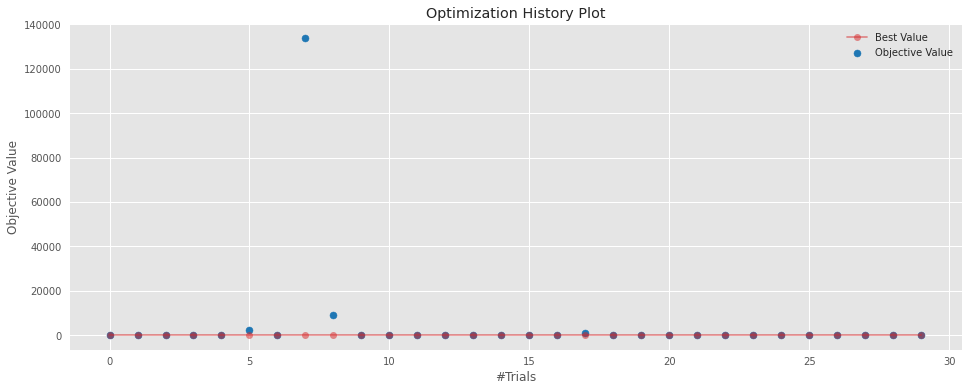

In [33]:
plot_optimization_history(study);

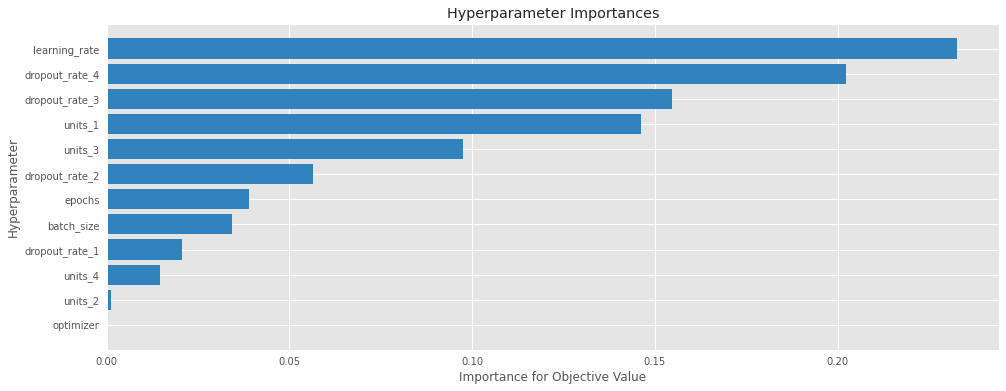

In [34]:
plot_param_importances(study);

In [35]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

## Model Training

In [36]:
model = Sequential()
model.add(LSTM(units=best_params['units_1'], return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=best_params['dropout_rate_1']))
model.add(LSTM(units=best_params['units_2'], return_sequences=True))
model.add(Dropout(rate=best_params['dropout_rate_2']))
model.add(LSTM(units=best_params['units_3'], return_sequences=True))
model.add(Dropout(rate=best_params['dropout_rate_3']))
model.add(LSTM(units=best_params['units_4']))
model.add(Dropout(rate=best_params['dropout_rate_4']))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer=best_params['optimizer'](learning_rate=best_params['learning_rate']), metrics=['accuracy'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_120 (LSTM)              (None, 1, 2550)           26040600  
_________________________________________________________________
dropout_120 (Dropout)        (None, 1, 2550)           0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 1, 850)            11563400  
_________________________________________________________________
dropout_121 (Dropout)        (None, 1, 850)            0         
_________________________________________________________________
lstm_122 (LSTM)              (None, 1, 3250)           53313000  
_________________________________________________________________
dropout_122 (Dropout)        (None, 1, 3250)           0         
_________________________________________________________________
lstm_123 (LSTM)              (None, 3600)            

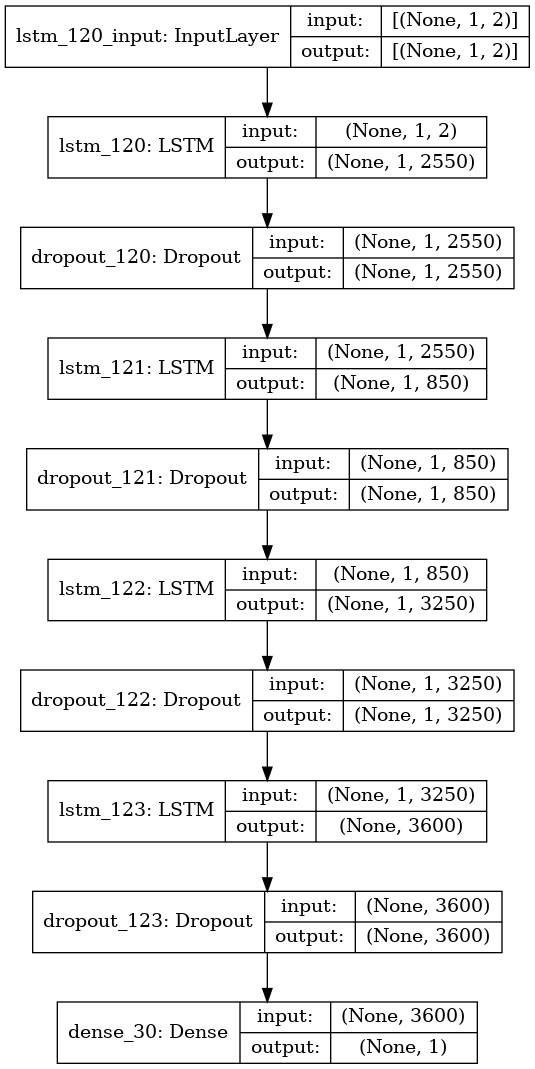

In [37]:
plot_model(model, show_shapes=True)

In [38]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 11min 30s, sys: 36.8 s, total: 12min 7s
Wall time: 30min 35s


## Model Evaluation

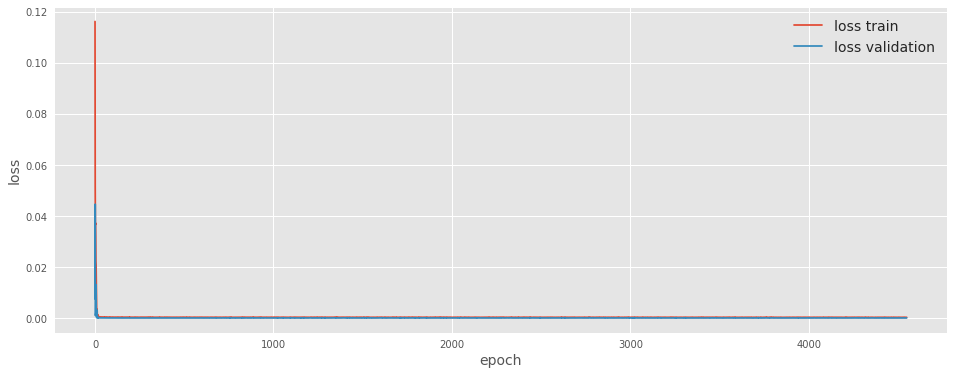

In [39]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [40]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

1/1 [==============================] - 0s 45ms/step - loss: 6.1913e-05 - accuracy: 0.0000e+00


[6.191290594870225e-05, 0.0]

## Prediction

In [41]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

In [42]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(1527,) (190,)


In [43]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [122.20814353 118.52097705 117.69803261 116.70519001 117.89270104]
Train Actual:  [115. 114. 113. 114. 111.]
Test Predicted:  [418.92220744 417.39459312 413.09990093 405.82345036 405.43408427]
Test Actual:  [415. 411. 404. 403. 402.]


## Loss Analysis

In [44]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.58 RMSE
Test Score: 7.72 RMSE


## Plotting Predictions

In [45]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

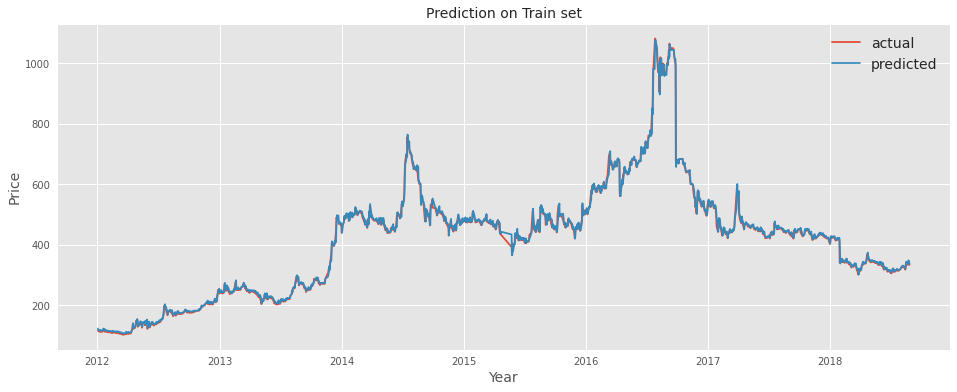

In [46]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

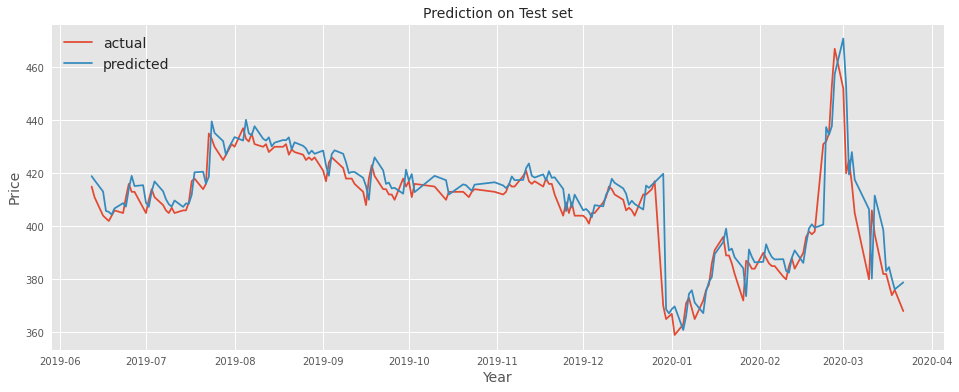

In [47]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()